In [1]:
import numpy as np
import cvxopt as cvx
import matplotlib
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
matplotlib.rcParams['figure.figsize'] = (4, 4)

### define some constants

In [2]:
g=9.8     #gravity on earth
A0 = 0.01 #unit section of a bar (in m2)
D = 450.  #density of the bar (kg/m3)
E = 9 #young elasticity modulus (in GPa) --> so u = K^-1 f is in nm

This function defines the variables `nodes`, `bars` and `dofs` of the "cristmas structure"; cf. the file ``5_truss_design.ipynb`` for more info.

In [3]:
def christmas_star():
    nodes = np.array([
    [0,9],#node 0
    [2,8.5],#node 1
    [8,8.5],#node 2
    [9,8.5],#node 3
    [14,8.5],#node 4
    [20,9],#node 5
    
    [7,7],#node 6
    [10,7],#node 7
    [6,5.5],#node 8
    [11,5.5],#node 9
    [8.5,4.5],#node 10
     
    [9.1,5.5],#node 11
    [11,5],#node 12
    [16,4.8],#node 13
    [19,5.2],#node 14
    [10.5,4.5],#node 15
    [15,4.2],#node 16
    [18,4.6],#node 17
    [10.5,3.8],#node 18
    [16,3.5],#node 19
    [19,4.4],#node 20
    ])

    dofs = np.ones(nodes.shape)
    dofs[0,0] = 0.;dofs[0,1] = 0. #node 0 does not move
    dofs[5,0] = 0.;dofs[5,1] = 0. #node 5 does not move
    

    bars = [#upper part
            [0,1],
            [1,2],
            [2,3],
            [3,4],
            [4,5],
            #star
            [6,9],
            [6,10],
            [7,8],
            [7,10],
            [8,9],
            #trace
            [11,12],
            [12,13],
            [13,14],
            [11,15],
            [15,16],
            [16,17],
            [11,18],
            [18,19],
            [19,20],
            #small bars
            [1,8],
            [2,6],
            [3,7],
            [4,9],
            [1,6],
            [4,7],
            [0,8],
            [11,9],
            [11,10],
            [10,9],
            [12,16],
            [15,13],
            [16,18],
            [15,19],
            [12,15],
            [13,16],
            [15,18],
            [16,19],
            [16,20],
            [19,17],
            [16,14],
            [13,17],
            [9,12],
            [10,18],            
           ]
    return nodes,dofs,bars

We define the functions `stiffness_vectors`, `stiffness_matrix`, and `draw_truss` as we did in the file ``5_truss_design.ipynb``.

In [4]:
def stiffness_vectors():
    v = []
    n = len(nodes)
    m = len(bars)
    d = nodes.shape[1]
    dof_mask = np.concatenate(dofs,axis=0)
    for k,(i,j) in enumerate(bars):
        L = np.linalg.norm(nodes[i]-nodes[j])
        angles = (nodes[j]-nodes[i])/L
        vk = np.array([0.]*d*n)
        vk[d*i:d*(i+1)] = angles
        vk[d*j:d*(j+1)] = -angles
        vk *= (E*A0/L)**0.5
        v.append(cvx.matrix(vk[dof_mask==1]))
    return v
            
def stiffness_matrix(x=None):
    n = len(bars)
    if x is None:
        x=[1]*n
    v = stiffness_vectors()
    m = len(v[0])
    K = cvx.matrix(0,(m,m))
    for i in range(n):
        K = K + x[i]*v[i]*v[i].T
    return K

def draw_truss(x=None,f=None, delta = 1.):
    if x is None:
        x=[1]*len(bars)
    for k,(i,j) in enumerate(bars):
        plt.plot([nodes[i][0],nodes[j][0]],[nodes[i][1],nodes[j][1]],linewidth = 3*x[k],color='blue')
    
    minx,miny = np.min(nodes,axis=0)
    maxx,maxy = np.max(nodes,axis=0)
    plt.xlim(minx-0.2,maxx+0.2)
    plt.ylim(miny-0.2,maxy+.2)
    
    if f is not None:
        K = stiffness_matrix(x=x)
        dof_mask = np.concatenate(dofs,axis=0)
        ff = f.ravel()[dof_mask==1] #projection on coordinates of the degrees of freedom
        dx = np.zeros(nodes.shape[0]*nodes.shape[1])
        dx[dof_mask==1] = np.linalg.lstsq(K,ff)[0]*1e-9 #1e-9 because E is in GPa
        dx= np.reshape(dx,nodes.shape)
        dnodes = nodes + delta * dx
        for k,(i,j) in enumerate(bars):
            plt.plot([dnodes[i][0],dnodes[j][0]],[dnodes[i][1],dnodes[j][1]],linewidth = 3*x[k],color='red')

### Let's draw the truss for a reference solution $x_0$, and compute its "volume" $W = \langle L,x_0 \rangle$

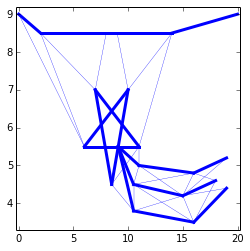

In [5]:
nodes,dofs,bars = christmas_star()
m = len(bars)
x0 = np.array([1.]*m)
x0[19:]=0.1
Lbars = [np.linalg.norm(nodes[i]-nodes[j]) for i,j in bars]
W = x0.dot(Lbars) #("volume" of this truss)
draw_truss(x=x0)

### Now we define the forces corresponding to 2 extreme scenarios:

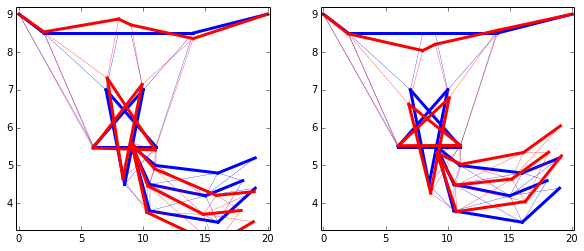

In [6]:
n = len(nodes)
F1 = np.zeros((n,2))
F1[6:20,0]=-500
F1[6:20,1]=-10*g

F2 = np.zeros((n,2))
F2[6:20,0]=800
F2[6:20,1]=-10*g

fig=plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
draw_truss(x=x0,f=F1,delta=1)
ax2 = fig.add_subplot(122)
draw_truss(x=x0,f=F2,delta=1)

Formulate as an SDP the problem of finding the design weight that minimizes the worst-case compliance for these 2 scenarios: $\operatorname{minimize}\ \max(f_1^TK^{−1}f_1,f_2^TK^{−1}f_2)$.
The structure is subject to the following constraints:
* bars i=19,...,m have a bounded size ($x_i \leq 0.2$);
* All other bars have size at least $x_i\geq 0.5$;
* bars i=5,...,9 (the star) must have the same scale;
* bars i=10,...,18 have a smaller scale than the bars of the star (i=5...9);
* There is a constraint on the total volume: $\sum_i x_i L_i \leq W$.

*** Dualizing the problem...  ***
--------------------------
  cvxopt CONELP solver
--------------------------
     pcost       dcost       gap    pres   dres   k/t
 0:  7.8693e-17  6.7363e-17  2e+02  1e+01  2e-01  1e+00
 1:  1.5545e-01 -6.7300e-02  3e+01  3e+00  5e-02  6e-03
 2:  6.2126e-02  3.9452e-02  2e+00  4e-01  7e-03  8e-03
 3:  4.8582e-03  3.2690e-03  2e-01  5e-02  1e-03  3e-03
 4:  4.4631e-04  2.7329e-04  8e-03  3e-03  6e-05  1e-04
 5:  1.9722e-05  1.1624e-05  3e-04  1e-04  2e-06  2e-06
 6:  1.6423e-06  9.2675e-07  2e-05  1e-05  2e-07  2e-07
 7:  1.1461e-06  5.6099e-07  2e-05  9e-06  2e-07  1e-07
 8: -1.7784e-07 -2.9281e-07  4e-06  2e-06  3e-08  3e-08
 9: -2.7181e-07 -3.6341e-07  3e-06  1e-06  2e-08  2e-08
10: -5.3375e-07 -5.5390e-07  7e-07  3e-07  5e-09  5e-09
11: -5.4012e-07 -5.5666e-07  6e-07  3e-07  4e-09  4e-09
12: -5.6768e-07 -5.7220e-07  2e-07  7e-08  1e-09  1e-09
13: -5.6863e-07 -5.7259e-07  2e-07  6e-08  1e-09  1e-09
14: -5.5364e-07 -5.5574e-07  1e-07  4e-08  6e-10  8

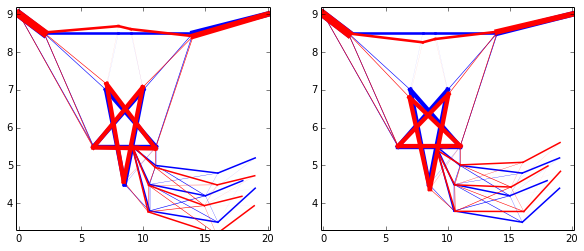

In [12]:
import picos as pic
n = len(nodes)
m = len(bars)
LL = pic.new_param('LL',Lbars)

P = pic.Problem()
x = P.add_variable('x',m)
dof_mask = np.concatenate(dofs,axis=0)
f1 = F1.ravel()[dof_mask==1]   #project force on coordinates of degrees of freedom
f2 = F2.ravel()[dof_mask==1]   
f1 = pic.new_param('f1',f1/1e9) #divide by 1e9 for the sake of numerical accuracy
f2 = pic.new_param('f2',f2/1e9)

#define the stiffness matrix (note: this is a linear expression w.r.t. x)
K = stiffness_matrix(x)

# ------

# 1. choose a variable to represent the length of the bars; initialize it with 1
v = P.add_variable('v',1)

# 2. we set up the lagranian dual for the problem
P.add_constraint( ((K & f1)// (f1.T & v)) >> 0)
P.add_constraint( ((K & f2)// (f2.T & v)) >> 0)

# 3. we add constraints for the bounded size of the bars
P.add_constraint(x[19:]<=0.2)
P.add_constraint(x[:19]>=0.5)
# 4. add equality-constraints for some bars
P.add_constraint(x[6]==x[5])
P.add_constraint(x[7]==x[5])
P.add_constraint(x[8]==x[5])
P.add_constraint(x[9]==x[5])
# 5. add inequality-constraints for some bars
for i in range(10,m):
    P.add_constraint(x[i]<=x[5])

# 6. add constraint for Volume; replace sum by vector-multiplication
P.add_constraint((LL|x)<=W)

# 7. add the objective
P.set_objective('min',v)
P.solve()


# -----


fig=plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
draw_truss(x=x.value,f=F1,delta=1)
ax2 = fig.add_subplot(122)
draw_truss(x=x.value,f=F2,delta=1)